# pyPCGA-MARE2DEM tutorial example - resistivity estimation for MT survey

## Problem description

+ Domain: 2 x 2 km
+ 10000 (nx, nz = 100, 100) log-normal resistivity using Gaussian covariance kernel with scale parameter of [500, 200] m 
+ Number of unkonwns: 10,000 resistivities
+ Measurements: 5,248 (21 recievers x 32 frequency bands, EM amplitude and phase) and noise level 0.1

In [1]:
%matplotlib inline

- Test environments

In [2]:
import sys
print(sys.version)

2.7.15 |Anaconda custom (64-bit)| (default, May  1 2018, 23:32:55) 
[GCC 7.2.0]


In [3]:
import platform
print(platform.platform()) # ubuntu 18.04

Linux-4.4.0-135-generic-x86_64-with-debian-stretch-sid


In [4]:
import numpy as np
print(np.__version__)

1.14.0


In [5]:
import psutil
print('# of physcial CPU cores %s' % (psutil.cpu_count(logical=False)))

# of physcial CPU cores 36


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import mare2dem
from pyPCGA import PCGA
import math
import warnings; warnings.simplefilter('ignore')

In [7]:
# model domain and discretization
nx = ny = 100    
m = nx*ny
N = np.array([nx,ny])
xmin = np.array([0,0])
xmax = np.array([2000.0,2000.0])
pts = None # While MARE2DEM supports unstructured grids, here we use equally spaced points interpolated from FE grids to use FFT. will update it later  

In [8]:
# load observations and synthetic true and define intial guess
s_true = np.loadtxt('true_100x100.txt')
obs = np.loadtxt('obs.txt')
s_init = np.mean(s_true) * np.ones((m, 1))

- True resistivity field (nx = 100, nz = 100)
- At the ground surface (z = 0 m), 21 recievers were employed to measure EM amplitude and phase (with 32 frequency bands)

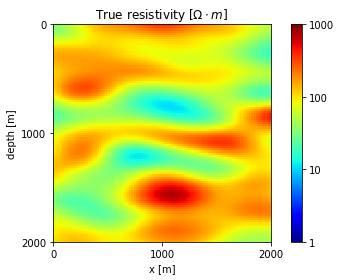

In [9]:
plt.title(r'True resistivity ' + r'$[\Omega \cdot m]$')
im0 = plt.imshow(s_true.reshape(ny,nx), vmin = 0, vmax = np.log(1000), cmap=plt.get_cmap('jet'),extent=(0,2000,2000,0))
plt.xticks(np.linspace(0,2000,3))
plt.yticks(np.linspace(0,2000,3))
plt.xlabel('x [m]')
plt.ylabel('depth [m]')
plt.gca().set_aspect('equal','box-forced')
cbar = plt.colorbar(im0, ticks=[np.log(1),np.log(10), np.log(100),np.log(1000)])
cbar.ax.set_yticklabels(['1','10','100','1000'])
plt.tight_layout()
plt.show()


In [10]:
# covairance kernel and scale parameters
prior_std = 1.0
prior_cov_scale = np.array([500.0,200.0])

def kernel(r): return (prior_std ** 2) * np.exp(-r**2)


In [11]:
# forward model wrapper for pyPCGA
# prepare interface to run as a function
def forward_model(s, parallelization, ncores=None):
    params = {'nx':nx,'ny':ny}
    model = mare2dem.Model(params)

    if parallelization:
        simul_obs = model.run(s, parallelization, ncores)
    else:
        simul_obs = model.run(s, parallelization)
    return simul_obs

In [12]:
# PCGA parameters
params = {'R': (0.1) ** 2, 'n_pc': 50,
        'maxiter': 4, 'restol': 0.1,
        'matvec': 'FFT', 'xmin': xmin, 'xmax': xmax, 'N': N,
        'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
        'kernel': kernel, 'post_cov': "diag",
        'precond': True, 'LM': True,
        'parallel': True, 'linesearch': True,
        'forward_model_verbose': False, 'verbose': False,
        'iter_save': True, 'precision':1.E-4}

# Inversion
- intialize pyPCGA

In [13]:
# initialize
prob = PCGA(forward_model, s_init, pts, params, s_true, obs)


##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 10000
   Number of observations                           : 5248
   Number of principal components (n_pc)            : 50
   Prior model                                      : def kernel(r): return (prior_std ** 2) * np.exp(-r**2)

   Prior variance                                   : 1.000000e+00
   Prior scale (correlation) parameter              : [500. 200.]
   Posterior cov computation                        : diag
   Posterior variance computation                   : Approx.
   Number of CPU cores (n_core)                     : 36
   Maximum GN iterations                            : 4
   machine precision (delta = sqrt(precision))      : 1.000000e-04
   Tol for iterations (norm(sol_diff)/norm(sol))    : 1.000000e-01
   Levenberg-Marquardt (LM)                         : True
   LM solution

- run pyPCGA

In [14]:
# run inversion
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 10000) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 50 is 1 sec
- 1st eigv : 679.49, 50-th eigv : 26.2092, ratio: 0.0385719
##### 4. Start PCGA Inversion #####
-- evaluate initial solution
obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 1.58547, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 15.8547
***** Iteration 1 ******
computed Jacobian-Matrix products in 339.351796 secs
solve saddle point (co-kriging) systems with Levenberg-Marquardt
evaluate LM solutions
LM solution evaluted
- Geostat. inversion at iteration 1 is 584 sec
== iteration 1 summary ==
= objective function is 3.176244e+04, relative L2-norm diff btw sol 0 and sol 1 is 0.12728
= L2-norm error (w.r.t truth) is 21.1994, obs. RMSE is 0.347885, obs. normalized RMSE is 3.47885
- save results in text at iteration 1
***** Iteration 2 ******
computed Jacobian-Matrix products in 339.822

# Post-processing

[Text(1,0,'1'), Text(1,0,'10'), Text(1,0,'100'), Text(1,0,'1000')]

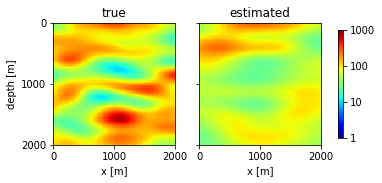

In [15]:
fig, ax = plt.subplots(nrows=1,ncols=2,sharey=True)
im0 = ax[0].imshow(s_true.reshape(ny,nx),vmin=0,vmax=np.log(1000), cmap=plt.get_cmap('jet'),extent=(0,2000,2000,0))
ax[0].set_title('true')
ax[0].set_aspect('equal','box-forced')
ax[1].imshow(s_hat.reshape(ny,nx),vmin=0,vmax=np.log(1000), cmap=plt.get_cmap('jet'),extent=(0,2000,2000,0))
ax[1].set_title('estimated')
ax[1].set_aspect('equal','box-forced')
ax[0].set_xticks(np.linspace(0,2000,3))
ax[0].set_yticks(np.linspace(0,2000,3))
ax[1].set_xticks(np.linspace(0,2000,3))
ax[0].set_ylabel('depth [m]')
ax[0].set_xlabel('x [m]')
ax[1].set_xlabel('x [m]')

cbar = fig.colorbar(im0, ticks=[np.log(1),np.log(10), np.log(100),np.log(1000)],ax=ax.ravel().tolist(),shrink=0.5)
cbar.ax.set_yticklabels(['1','10','100','1000'])

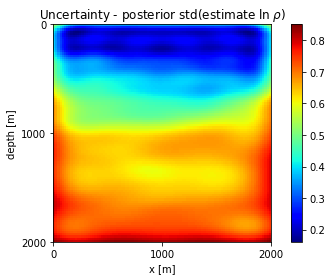

In [16]:
post_std = np.sqrt(post_diagv)

plt.title(r'Uncertainty - posterior std(estimate $\ln \; \rho$)')
im0 = plt.imshow(post_std.reshape(ny,nx), cmap=plt.get_cmap('jet'),extent=(0,2000,2000,0))
plt.gca().set_aspect('equal','box-forced')
plt.xticks(np.linspace(0,2000,3))
plt.yticks(np.linspace(0,2000,3))
plt.xlabel('x [m]')
plt.ylabel('depth [m]')
plt.colorbar(im0)
plt.tight_layout()

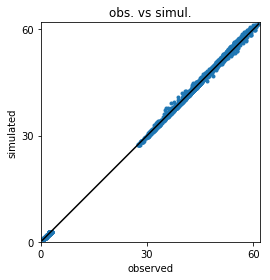

In [17]:
nobs = obs.shape[0]
plt.title('obs. vs simul.')
plt.plot(obs, simul_obs, '.')
plt.xlabel('observed')
plt.ylabel('simulated')
minobs = np.hstack((obs, simul_obs.reshape(-1))).min()
maxobs = np.hstack((obs, simul_obs.reshape(-1))).max()
plt.plot(np.linspace(minobs, maxobs, 20), np.linspace(minobs, maxobs, 20), 'k-')
axes = plt.gca()
axes.set_xlim([math.floor(minobs), math.ceil(maxobs)])
axes.set_ylim([math.floor(minobs), math.ceil(maxobs)])
plt.gca().set_aspect('equal','box-forced')
plt.xticks(np.linspace(0,60,3))
plt.yticks(np.linspace(0,60,3))
plt.tight_layout()